# AfD’s Performance in the 2025 German Federal Election: A Regional and Demographic Analysis

## Introduction

In this project, I analyze the performance of the **Alternative für Deutschland (AfD)** in the 2025 German federal election, with a focus on their second vote share (Zweitstimme) across different regions of Germany.

To conduct this analysis, I used four official datasets sourced from the [Federal Returning Officer (Bundeswahlleiter)](https://www.bundeswahlleiterin.de/bundestagswahlen/2025/ergebnisse/opendata.html), which are publicly available and legally approved.

The datasets include:

- Vote share and seat counts — **kerg.csv**, **kerg2.csv**  
- Candidate demographics — **bewerber.csv**
- Regional structure and socio-economic data — **struktur.csv**

**Objectives of the project:**

- Explore regional voting patterns for AfD  
- Analyze how demographic and economic factors (e.g., unemployment, population density, migration background) relate to AfD's support  
- Compare AfD's candidate profile with other major parties  
- Present key findings through data visualizations for clarity and insight

This project aims to provide a deeper understanding of where and why AfD performed strongly in 2025, and what this might indicate about voter behavior across Germany.


## Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')




## Loading the Datasets

In [12]:
# File paths
kerg_path = "kerg.csv"
kerg2_path = "kerg2.csv"
bewerber_path = "btw25_bewerb_utf8.csv"
struktur_path = "btw2025_strukturdaten.csv"

# Load kerg2.csv (vote share & change) — special case with multi-row headers
kerg2 = pd.read_csv(kerg2_path, sep=";", encoding="latin1", skiprows=6, header=[0, 1])

# Flatten multi-index columns into single row
kerg2.columns = ['_'.join(col).strip() if col[1] else col[0] for col in kerg2.columns.values]

# Drop first two garbage rows
kerg2 = kerg2.iloc[2:].reset_index(drop=True)

# Load the remaining datasets
kerg = pd.read_csv(kerg_path, sep=";", encoding="latin1", skiprows=8, on_bad_lines='skip')
bewerber = pd.read_csv(bewerber_path, sep=";", encoding="utf-8", skiprows=8, on_bad_lines='skip')
struktur = pd.read_csv(struktur_path, sep=";", encoding="latin1", skiprows=10, on_bad_lines='skip')

# Shape overview
print("kerg2 (vote share & change):", kerg2.shape)
print("kerg  (absolute counts/seats):", kerg.shape)
print("bewerber (candidates):", bewerber.shape)
print("struktur (region structure):", struktur.shape)


kerg2 (vote share & change): (15617, 17)
kerg  (absolute counts/seats): (331, 141)
bewerber (candidates): (6365, 35)
struktur (region structure): (315, 52)


### Explanation
In this block, I imported four datasets related to the German federal elections 2025. Upon inspection, I noticed that the initial rows in each file contained metadata or formatting information rather than actual data. To handle this, I skipped the irrelevant rows while loading and specified the correct separator (;) and encoding for each file. For the dataset with multi-row headers (kerg2.csv), I also flattened the column structure and removed additional non-data rows. Finally, I displayed the shape of all datasets to confirm they were loaded correctly and to get an overview of their dimensions.

## Preview of Raw Datasets

In [15]:
print("\n===== kerg2 (Vote %, Difference from 2021) =====\n")
print(kerg2.head())

print("\n===== kerg (Absolute Votes & Seats) =====\n")
print(kerg.head())

print("\n===== bewerber (Candidate Info) =====\n")
print(bewerber.head())

print("\n===== struktur (Demographics) =====\n")
print(struktur.head())



===== kerg2 (Vote %, Difference from 2021) =====

  Unnamed: 0_level_0_Format: CSV. Trennzeichen: Semikolon. Zeichensatz: UTF-8 mit BOM  \
0                                                 BT                                    
1                                                 BT                                    
2                                                 BT                                    
3                                                 BT                                    
4                                                 BT                                    

  Unnamed: 1_level_0_Unnamed: 1_level_1 Unnamed: 2_level_0_Unnamed: 2_level_1  \
0                            23.02.2025                                  Bund   
1                            23.02.2025                                  Bund   
2                            23.02.2025                                  Bund   
3                            23.02.2025                                  Bund   
4        

## Data Understanding & Basic Inspection

In [17]:
# Basic structure and null check for each dataset
print("\nkerg2 (Vote %, Difference from 2021):")
print(kerg2.info())


kerg2 (Vote %, Difference from 2021):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15617 entries, 0 to 15616
Data columns (total 17 columns):
 #   Column                                                                               Non-Null Count  Dtype 
---  ------                                                                               --------------  ----- 
 0   Unnamed: 0_level_0_Format: CSV. Trennzeichen: Semikolon. Zeichensatz: UTF-8 mit BOM  15617 non-null  object
 1   Unnamed: 1_level_0_Unnamed: 1_level_1                                                15617 non-null  object
 2   Unnamed: 2_level_0_Unnamed: 2_level_1                                                15617 non-null  object
 3   Unnamed: 3_level_0_Unnamed: 3_level_1                                                15617 non-null  object
 4   Unnamed: 4_level_0_Unnamed: 4_level_1                                                15617 non-null  object
 5   Unnamed: 5_level_0_Unnamed: 5_level_1                   

In [18]:
# Basic info and missing values
print("\nkerg (Absolute Votes & Seats):")
kerg.info()
kerg.isnull().sum().sort_values(ascending=False)


kerg (Absolute Votes & Seats):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Columns: 141 entries, 001 to Unnamed: 140
dtypes: float64(139), object(2)
memory usage: 364.7+ KB


Unnamed: 140    331
Unnamed: 127    331
Unnamed: 84     331
Unnamed: 109    331
Unnamed: 113    331
               ... 
45508            16
30558            16
38927            16
28376            16
001              16
Length: 141, dtype: int64

In [19]:
print("\nbewerber (Candidate Info):")
bewerber.info()
bewerber.isnull().sum().sort_values(ascending=False)


bewerber (Candidate Info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6365 entries, 0 to 6364
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Wahlart              6365 non-null   object 
 1   Wahltag              6365 non-null   object 
 2   Titel                488 non-null    object 
 3   Namenszusatz         53 non-null     object 
 4   Nachname             6365 non-null   object 
 5   Vornamen             6365 non-null   object 
 6   Rufname              6365 non-null   object 
 7   Künstlername         9 non-null      object 
 8   Geschlecht           6365 non-null   object 
 9   Geburtsjahr          6365 non-null   int64  
 10  PLZ                  6365 non-null   int64  
 11  Wohnort              6365 non-null   object 
 12  Staat                3 non-null      object 
 13  WohnortLandAbk       6365 non-null   object 
 14  Geburtsort           6365 non-null   object 
 15  Staatsange

Staatsangehörigkeit    6365
Staat                  6362
Künstlername           6356
Namenszusatz           6312
Titel                  5877
VorpGewaehlt           5275
VerknListenplatz       4506
Listenplatz            2665
VerknKennzeichen       2647
VerknGebietsart        2647
VerknGebietsnummer     2647
VerknGebietsname       2647
VerknGebietLandAbk     2647
VerknGruppenname       2647
GruppennameKurz          96
Gebietsnummer             0
Gruppenreihenfolge        0
Gruppenname               0
GebietLandAbk             0
Gebietsname               0
Wahlart                   0
Gebietsart                0
Kennzeichen               0
Wahltag                   0
Beruf                     0
Geburtsort                0
WohnortLandAbk            0
Wohnort                   0
PLZ                       0
Geburtsjahr               0
Geschlecht                0
Rufname                   0
Vornamen                  0
Nachname                  0
Berufsschlüssel           0
dtype: int64

In [20]:
print("\nstruktur (Demographics):")
struktur.info()
struktur.isnull().sum().sort_values(ascending=False)


struktur (Demographics):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Schleswig-Holstein       315 non-null    object
 1   1                        315 non-null    int64 
 2   Flensburg â Schleswig  315 non-null    object
 3   124                      315 non-null    int64 
 4   2128,1                   315 non-null    object
 5   301,2                    315 non-null    object
 6   271,7                    315 non-null    object
 7   9,8                      315 non-null    object
 8   141,5                    315 non-null    object
 9   -6,1                     315 non-null    object
 10  18,0                     315 non-null    object
 11  16,9                     315 non-null    object
 12  7,7                      315 non-null    object
 13  12,3                     315 non-null    object
 14  32,1            

Unnamed: 51                252
1                            0
9,9                          0
9,5                          0
23,2                         0
34,0                         0
33,2                         0
41,9                         0
92,1                         0
23052                        0
34278                        0
357,9                        0
1,7                          0
19,6                         0
26,6                         0
15,3                         0
36,8                         0
71,1                         0
25,9                         0
37,9                         0
6,3                          0
6,9                          0
5,7.1                        0
6,0                          0
6,1                          0
3,5                          0
Schleswig-Holstein           0
40,0                         0
7,7                          0
Flensburg â Schleswig      0
124                          0
2128,1                       0
301,2   

## Data Cleaning

In [22]:
#kerg2

In [23]:
#Step 1: Re-loading kerg2 with two header rows
kerg2_raw = pd.read_csv(kerg2_path, sep=";", encoding="latin1", skiprows=6, header=[0, 1])

#Step 2: Flatten multi-index column headers
kerg2_raw.columns = ['_'.join(col).strip() if col[1] else col[0] for col in kerg2_raw.columns.values]

#Step 3: Remove the metadata rows 
kerg2 = kerg2_raw.iloc[2:].reset_index(drop=True)

#Step 4: Rename the columns to English (except Region_Type & Region_Name)
kerg2.columns = [
    "Election_Type", "Election_Date", "Region_Type", "Region_Code", "Region_Name",
    "SubRegion_Type", "SubRegion_Code", "Group_Type", "Group_Name",
    "Group_Order", "Vote_Type", "Vote_Count", "Vote_Percent",
    "Prev_Vote_Count", "Prev_Vote_Percent", "Diff_Percent", "Diff_Points"
]

#Step 5: Fixing mojibake in Region_Name (ü, ö, ß, etc.)
kerg2["Region_Name"] = kerg2["Region_Name"].astype(str)
def fix_encoding(text):
    try:
        return text.encode("latin1").decode("utf-8")
    except:
        return text
kerg2["Region_Name"] = kerg2["Region_Name"].apply(fix_encoding)

#Step 6: Fixing mojibake in Group_Type
kerg2["Group_Type"] = (
    kerg2["Group_Type"]
    .astype(str)
    .str.encode("latin1", errors="ignore")
    .str.decode("utf-8", errors="ignore")
)

#Step 7: Fixing mojibake in Group_Name
kerg2["Group_Name"] = (
    kerg2["Group_Name"]
    .astype(str)
    .str.encode("latin1", errors="ignore")
    .str.decode("utf-8", errors="ignore")
)

#Step 8: Converting the numeric columns to float
cols_to_convert = [
    "Vote_Count", "Vote_Percent", "Prev_Vote_Count", "Prev_Vote_Percent",
    "Diff_Percent", "Diff_Points"
]
for col in cols_to_convert:
    kerg2[col] = (
        kerg2[col]
        .str.replace(",", ".", regex=False)
        .str.replace("−", "-", regex=False)  # Handle special minus
        .str.replace("%", "", regex=False)
    )
    kerg2[col] = pd.to_numeric(kerg2[col], errors="coerce")

#Translation of dictionaries for categorical row values
subregion_type_map = {
    "Bund": "Federal", "Land": "State", "Kreis": "District", "Wahlkreis": "Constituency"
}
group_type_map = {
    "System-Gruppe": "System Group",
    "Partei": "Party",
    "Einzelbewerber": "Independent",
    "Einzelbewerber/Wählergruppe": "Independent / Voter Group"
}
vote_type_map = {
    "1": "First Vote", "2": "Second Vote"
}
group_name_map = {
    "Wahlberechtigte": "Eligible Voters",
    "Wählende": "Voters",
    "Ungültige": "Invalid Votes",
    "Gültige": "Valid Votes",
    "Übrige": "Others",
    "Einzelbewerber/Wählergruppe": "Independent / Voter Group"
}

# Applying translations (keeping Region_Type & Region_Name in German)
kerg2["SubRegion_Type"] = kerg2["SubRegion_Type"].map(subregion_type_map).fillna(kerg2["SubRegion_Type"])
kerg2["Group_Type"] = kerg2["Group_Type"].map(group_type_map).fillna(kerg2["Group_Type"])
kerg2["Vote_Type"] = kerg2["Vote_Type"].map(vote_type_map).fillna(kerg2["Vote_Type"])
kerg2["Group_Name"] = kerg2["Group_Name"].replace(group_name_map)

# Final checks
print("kerg2 cleaned. Shape:", kerg2.shape)
print("Sample Region Names:", kerg2['Region_Name'].dropna().unique()[:5])
print("Sample Group Names:", kerg2['Group_Name'].dropna().unique()[:5])
print("Unique Group_Types:", kerg2["Group_Type"].unique())


kerg2 cleaned. Shape: (15617, 17)
Sample Region Names: ['Bundesgebiet' 'Schleswig-Holstein' 'Mecklenburg-Vorpommern' 'Hamburg'
 'Niedersachsen']
Sample Group Names: ['Eligible Voters' 'Voters' 'Invalid Votes' 'Valid Votes' 'SPD']
Unique Group_Types: ['System Group' 'Party' 'Independent / Voter Group']


### Explanation
In this step, I cleaned the kerg2.csv dataset by removing metadata rows, flattening multi-row headers, and fixing encoding issues. I translated all column headers from German to English for better clarity. However, I kept the data in columns like Region_Type, Region_Name, and Group_Type in German to retain geographic and political authenticity. I also cleaned and converted numeric columns for accurate analysis and applied translation mappings to selected categorical values. 

In [25]:
#kerg

In [26]:
# Renaming only the first 16 core columns of kerg.csv
kerg.columns.values[:16] = [
    "Region_Code", "Region_Name", "State_Code", "District_Code",
    "Eligible_Voters_1", "Eligible_Voters_2",
    "Eligible_Voters_1_Copy", "Eligible_Voters_2_Copy",
    "Valid_Votes_1", "Valid_Votes_2",
    "Valid_Votes_1_Copy", "Valid_Votes_2_Copy",
    "Votes_Party_1", "Votes_Party_2",
    "Seats_1", "Seats_2"
]

# Dropping the columns that are fully null
kerg_cleaned = kerg.dropna(axis=1, how='all')

# Optional: Track which columns were dropped
dropped_cols = [col for col in kerg.columns if col not in kerg_cleaned.columns]
print(f"Dropped {len(dropped_cols)} fully-null columns: {dropped_cols[:5]}...")

# Fixing the encoding issues in 'Region_Name' and 'District_Code' columns
kerg_cleaned.loc[:, 'Region_Name'] = kerg_cleaned['Region_Name'].astype(str)
kerg_cleaned.loc[:, 'District_Code'] = kerg_cleaned['District_Code'].astype(str)

def fix_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except:
        return text  

kerg_cleaned.loc[:, 'Region_Name'] = kerg_cleaned['Region_Name'].apply(fix_encoding)
kerg_cleaned.loc[:, 'District_Code'] = kerg_cleaned['District_Code'].apply(fix_encoding)

# Preview cleaned dataset info
print("\nCleaned kerg.csv:")
kerg_cleaned.info()

# Optional: Show sample distinct cleaned values
print("\nUnique Region_Names (first 5):", kerg_cleaned['Region_Name'].unique()[:5])
print("Unique District_Code:", kerg_cleaned['District_Code'].unique())


Dropped 14 fully-null columns: ['Unnamed: 84', 'Unnamed: 104', 'Unnamed: 109', 'Unnamed: 113', 'Unnamed: 121']...

Cleaned kerg.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Columns: 127 entries, Region_Code to 563
dtypes: float64(125), object(2)
memory usage: 328.5+ KB

Unique Region_Names (first 5): ['Nordfriesland – Dithmarschen Nord' 'Steinburg – Dithmarschen Süd'
 'Rendsburg-Eckernförde' 'Kiel' 'Plön – Neumünster']
Unique District_Code: ['Christlich Demokratische Union Deutschlands' 'BÜNDNIS 90/DIE GRÜNEN'
 'Sozialdemokratische Partei Deutschlands' 'nan'
 'Alternative für Deutschland' '–' 'Die Linke'
 'Christlich-Soziale Union in Bayern e.V.']


### Explanation
In this step, I cleaned the kerg.csv dataset, which contains absolute vote counts and seat allocations. I started by renaming only the first 16 core column headers from German to English, as these fields were most relevant for my analysis (e.g., region codes, eligible and valid votes, seat counts). The rest of the columns were left unchanged for now. To reduce noise, I removed 14 columns that were entirely empty. Additionally, I addressed encoding issues in the Region_Name and District_Code columns to properly display special German characters. However, I deliberately kept the data in these two columns in German to preserve geographic and political authenticity, while only translating the headers for better readability.

In [28]:
#bewerber

In [29]:
# Step 1: Renaming the columns to standard names
bewerber.columns = [
    "Election_Year", "Election_Type", "State_Code", "State_Name",
    "Constituency_Code", "Constituency_Name", "Candidate_Number",
    "Party_Short", "Party_Long", "Last_Name", "First_Name",
    "Gender", "Birth_Year", "Profession", "Street_Address",
    "Postal_Code", "City", "Nomination_Type", "List_Position",
    "Direct_Candidate", "Elected", "Withdrawn", "Replacement",
    "Disqualified", "Remarks", "Contact_Info", "Email",
    "Phone", "Fax", "Website", "Additional_Info1",
    "Additional_Info2", "Additional_Info3", "Additional_Info4", "Comment"
]

# Step 2: Renaming the misaligned columns
bewerber = bewerber.rename(columns={
    'Election_Year': 'Election_Type',
    'Election_Type': 'Election_Date',
    'State_Code': 'Title',
    'State_Name': 'Name_Prefix',
    'Constituency_Code': 'Last_Name',
    'Constituency_Name': 'First_Name',
    'Candidate_Number': 'Alt_Name_Possibly',
    'Party_Short': 'Party_Unknown_1',
    'Party_Long': 'Gender',
    'Last_Name': 'Birth_Year',
    'First_Name': 'Person_ID',
    'Gender': 'City',
    'Birth_Year': 'Nationality',
    'Profession': 'State_Code',
    'Street_Address': 'Constituency',
    'City': 'Profession',
    'Phone': 'Nomination_Type_1',
    'Fax': 'Nomination_Type_2',
})

# Step 3: Drop the unnecessary columns
bewerber.drop(columns=['Alt_Name_Possibly', 'Party_Unknown_1', 'Email', 'Website', 'Contact_Info'], inplace=True, errors='ignore')

# Step 4: Translate Gender codes
gender_map = {'m': 'Male', 'w': 'Female', 'd': 'Diverse'}
bewerber['Gender'] = bewerber['Gender'].map(gender_map)

# Step 5: Translate Nomination Types
bewerber['Nomination_Type_1'] = bewerber['Nomination_Type_1'].replace({
    'Kreiswahlvorschlag': 'District List',
    'Landesliste': 'State List'
})

bewerber['Nomination_Type_2'] = bewerber['Nomination_Type_2'].replace({
    'Wahlkreis': 'Constituency',
    'Land': 'State'
})

# Step 6: Translate Comment column 
bewerber['Comment'] = bewerber['Comment'].replace({'X': 'Checked'})

# Step 7: Translate Profession 
profession_map = {
    'Politikwissenschaftler': 'Political Scientist',
    'Sozialarbeiter': 'Social Worker',
    'Lehrerin': 'Teacher',
    'Juristin': 'Lawyer',
    'MdB': 'Member of Parliament',
    'Goldschmiedin': 'Goldsmith',
    'Bankkaufmann': 'Bank Clerk',
    'Umweltökonomin': 'Environmental Economist',
    'Minister a. D.': 'Former Minister',
}
bewerber['Profession'] = bewerber['Profession'].replace(profession_map, regex=True)

# Step 8: Fill missing values for binary columns
binary_columns = ['Elected', 'Withdrawn', 'Replacement', 'Disqualified']
for col in binary_columns:
    if col in bewerber.columns:
        bewerber[col] = bewerber[col].fillna(False)

# Step 9: Dropping the fully empty columns
bewerber.dropna(axis=1, how='all', inplace=True)

### Explanation
In this step, I cleaned the bewerber.csv dataset containing information about individual candidates. I first renamed all column headers from German to English to improve clarity. However, similar to the previous datasets, I retained some values (like party names and regional identifiers) in German to preserve the political context and authenticity. Next, I resolved misalignments in the original columns by reassigning them to more meaningful labels, then removed unnecessary or irrelevant columns such as email, website, and alternate names. I translated categorical values for gender, nomination types, comments, and common professions using mapping dictionaries to make the dataset more interpretable.



In [31]:
#struktur

In [32]:
# Rename columns
struktur.columns = [
    "Source_Info", "Region_Code", "Region_Name", "Constituency_Code", "Constituency_Name",
    "Eligible_Voters_Total", "Eligible_Voters_Male", "Eligible_Voters_Female",
    "Population_Total", "Population_Male", "Population_Female",
    "Foreigners_Total", "Foreigners_Male", "Foreigners_Female",
    "Migration_Background_Total", "Migration_Background_Male", "Migration_Background_Female",
    "Employment_Total", "Employment_Male", "Employment_Female",
    "Unemployment_Total", "Unemployment_Male", "Unemployment_Female",
    "Area_km2", "Population_Density",
    "Average_Age_Total", "Average_Age_Male", "Average_Age_Female",
    "Households_Total", "Households_1_Person", "Households_2_Person",
    "Households_3_Person", "Households_4Plus_Person",
    "High_School_Graduates", "University_Graduates", "Without_Degree",
    "Avg_Household_Income", "Median_Household_Income",
    "Working_Population_Total", "Working_Population_Male", "Working_Population_Female",
    "Retired_Total", "Retired_Male", "Retired_Female",
    "Students_Total", "Students_Male", "Students_Female",
    "Disabilities_Total", "Disabilities_Male", "Disabilities_Female",
    "Other_Info_1", "Other_Info_2"
]

#Rename 'Source_Info' to 'State_Name' and drop 'Other_Info_1' & 'Other_Info_2' 
struktur.rename(columns={"Source_Info": "State_Name"}, inplace=True)
struktur.drop(columns=["Other_Info_1", "Other_Info_2"], inplace=True)

# Optional fix for common encoding errors in State_Name
struktur['State_Name'] = struktur['State_Name'].replace({
    'ThÃ¼ringen': 'Thüringen',
    'Baden-WÃ¼rttemberg': 'Baden-Württemberg'
})

#Step 1: Forward-fill missing state names 
struktur["State_Name"] = struktur["State_Name"].ffill()

#Step 2: Define columns to clean
location_cols = ['Region_Code', 'Region_Name', 'Constituency_Code', 'Constituency_Name']
fix_cols = ['Region_Name', 'Constituency_Name']

#Step 3: Strip whitespace
for col in location_cols:
    struktur[col] = struktur[col].astype(str).str.strip()

#Step 4: Fix encoding issues for German special characters
for col in fix_cols:
    struktur[col] = struktur[col].apply(
        lambda x: x.encode('latin1').decode('utf-8') if isinstance(x, str) else x
    )
struktur[fix_cols] = struktur[fix_cols].apply(lambda x: x.str.strip())

#Step 5: Renaming the incorrect column
struktur.rename(columns={"Constituency_Name": "Constituency_Value"}, inplace=True)

#Step 6: Converting the German-style numbers to float 
for col in struktur.columns:
    if col not in location_cols and col != "State_Name":
        struktur[col] = (
            struktur[col]
            .astype(str)
            .str.replace('.', '', regex=False)
            .str.replace(',', '.', regex=False)
        )
        struktur[col] = pd.to_numeric(struktur[col], errors='coerce')

#Step 7: Converting the whole-number floats to Int64 
for col in struktur.select_dtypes(include='float'):
    if (struktur[col] % 1 == 0).all():
        struktur[col] = struktur[col].astype('Int64')

#Step 8: Final checks 
print("\n'struktur' cleaned successfully!")
struktur.info()
print("\nMissing values (top 10 columns):")
print(struktur.isnull().sum().sort_values(ascending=False).head(10))


'struktur' cleaned successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   State_Name                   315 non-null    object 
 1   Region_Code                  315 non-null    object 
 2   Region_Name                  315 non-null    object 
 3   Constituency_Code            315 non-null    object 
 4   Constituency_Value           315 non-null    float64
 5   Eligible_Voters_Total        315 non-null    float64
 6   Eligible_Voters_Male         315 non-null    float64
 7   Eligible_Voters_Female       315 non-null    float64
 8   Population_Total             315 non-null    float64
 9   Population_Male              315 non-null    float64
 10  Population_Female            315 non-null    float64
 11  Foreigners_Total             315 non-null    float64
 12  Foreigners_Male              315 non-null   

### Explanation 
In this step, I cleaned the struktur.csv dataset, which contains demographic and socioeconomic indicators for each region. I renamed all columns to clear, English labels and removed two irrelevant fields. I corrected encoding issues in state and region names and applied forward-filling to populate missing state names. Whitespace and character encoding problems in geographic fields were also fixed, and German-style number formats were converted to standard float format. Additionally, numeric columns with only whole numbers were converted to integer type where appropriate. The dataset is now clean, well-structured, and ready for integration with other election-related data.

## Preview of Cleaned Datasets

In [35]:
print("\n===== kerg2 (Vote %, Difference from 2021) =====\n")
print(kerg2.head())

print("\n===== kerg (Absolute Votes & Seats) =====\n")
print(kerg_cleaned.head())

print("\n===== bewerber (Candidate Info) =====\n")
print(bewerber.head())

print("\n===== struktur (Demographics) =====\n")
print(struktur.head())



===== kerg2 (Vote %, Difference from 2021) =====

  Election_Type Election_Date Region_Type Region_Code   Region_Name  \
0            BT    23.02.2025        Bund          99  Bundesgebiet   
1            BT    23.02.2025        Bund          99  Bundesgebiet   
2            BT    23.02.2025        Bund          99  Bundesgebiet   
3            BT    23.02.2025        Bund          99  Bundesgebiet   
4            BT    23.02.2025        Bund          99  Bundesgebiet   

  SubRegion_Type SubRegion_Code    Group_Type       Group_Name Group_Order  \
0            NaN            NaN  System Group  Eligible Voters          -4   
1            NaN            NaN  System Group           Voters          -3   
2            NaN            NaN  System Group    Invalid Votes          -2   
3            NaN            NaN  System Group    Invalid Votes          -2   
4            NaN            NaN  System Group      Valid Votes          -1   

     Vote_Type  Vote_Count  Vote_Percent  Prev_Vote_C

## Merging AfD Vote Data with Regional Demographics by Constituency

In [37]:
# Step 1: Filter kerg2 to AfD + Second Vote + valid SubRegion_Code
afd_kerg2 = kerg2[
    (kerg2["Group_Name"] == "AfD") &
    (kerg2["Vote_Type"] == "Second Vote") &
    (kerg2["SubRegion_Code"].notna())
].copy()

# Step 2: Standardize the codes to string format with leading zeros (e.g., '001')
afd_kerg2["SubRegion_Code"] = afd_kerg2["SubRegion_Code"].astype(str).str.zfill(3)
struktur["Constituency_Code"] = struktur["Constituency_Code"].astype(str).str.zfill(3)

# Step 3: Removing national-level row (Bundesgebiet = '099')
afd_kerg2 = afd_kerg2[afd_kerg2["SubRegion_Code"] != "099"]

# Step 4: Merge on SubRegion_Code = Constituency_Code
afd_merged = afd_kerg2.merge(
    struktur,
    left_on="SubRegion_Code",
    right_on="Constituency_Code",
    how="left",
    suffixes=("_kerg2", "_struktur")
)

# Step 5: Drop the rows that didn't match (still NaN after merge)
afd_merged = afd_merged.dropna(subset=["State_Name", "Region_Name_struktur"])

print("\nMerge complete and cleaned. Sample:")
print(afd_merged[["Region_Name_kerg2", "SubRegion_Code", "Group_Name", "Vote_Percent", "State_Name", "Region_Name_struktur"]].head())


Merge complete and cleaned. Sample:
       Region_Name_kerg2 SubRegion_Code Group_Name  Vote_Percent State_Name  \
0  Flensburg – Schleswig            001        AfD     15.254255    Hamburg   
1  Flensburg – Schleswig            001        AfD     15.254255    Hamburg   
2  Flensburg – Schleswig            001        AfD     15.254255    Hamburg   
3  Flensburg – Schleswig            001        AfD     15.254255    Hamburg   
4  Flensburg – Schleswig            001        AfD     15.254255    Hamburg   

  Region_Name_struktur  
0        Hamburg-Mitte  
1       Hamburg-Altona  
2   Hamburg-Eimsbüttel  
3         Hamburg-Nord  
4     Hamburg-Wandsbek  


### Explanation
In this step, I prepared and merged AfD’s second vote results from kerg2.csv with demographic data from struktur.csv. I first filtered the dataset to include only AfD’s second vote records with valid subregion codes. I then standardized the region codes to a consistent three-digit string format to ensure a successful join. After excluding the national-level row (Bundesgebiet), I merged the datasets on SubRegion_Code and Constituency_Code. Post-merge, I removed any unmatched rows to retain only valid region-level entries. 

## Exploratory Data Analysis

### Plot 1: AfD Vote Share by State (Second Vote)

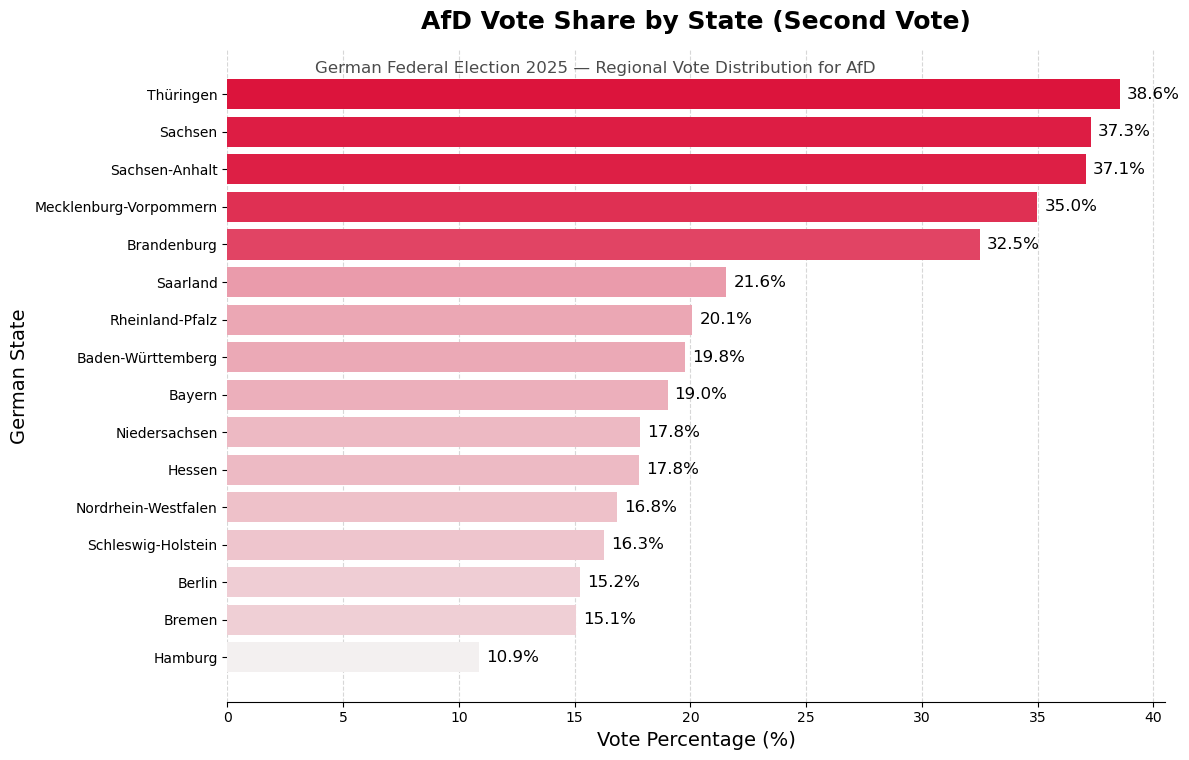

In [41]:
# Filter only AfD rows at state level
afd_state = kerg2[
    (kerg2["Group_Name"] == "AfD") &
    (kerg2["Vote_Type"] == "Second Vote") &
    (kerg2["Region_Type"] == "Land")
].copy()

# Sort ascending for horizontal bars bottom to top
afd_state = afd_state.sort_values(by="Vote_Percent", ascending=True)

plt.figure(figsize=(12, 8))

# Create a colormap normalized for vote percentages
cmap = sns.light_palette("crimson", as_cmap=True)
norm = plt.Normalize(afd_state["Vote_Percent"].min(), afd_state["Vote_Percent"].max())
colors = [cmap(norm(v)) for v in afd_state["Vote_Percent"]]

ax = plt.gca()
y_pos = range(len(afd_state))

# Plot each bar manually with corresponding color
for i, (value, name) in enumerate(zip(afd_state["Vote_Percent"], afd_state["Region_Name"])):
    ax.barh(i, value, color=colors[i])
    ax.text(value + 0.3, i, f"{value:.1f}%", va='center', fontsize=12, color='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(afd_state["Region_Name"])
ax.set_xlabel("Vote Percentage (%)", fontsize=14)
ax.set_ylabel("German State", fontsize=14)

# Main title and subtitle with vertical spacing
plt.title("AfD Vote Share by State (Second Vote)", fontsize=18, weight='bold', pad=15)
plt.suptitle("German Federal Election 2025 — Regional Vote Distribution for AfD", fontsize=12, y=0.88, alpha=0.7)

# Style grid and spines for cleaner look
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


### Explanation
This horizontal bar chart displays the AfD’s second vote percentage across German states in the 2025 federal election. Thüringen (38.6%), Sachsen (37.3%), and Sachsen-Anhalt (37.1%) recorded the highest support for AfD. In contrast, Hamburg (10.9%), Bremen (15.1%), and Berlin (15.2%) show the lowest support. The use of a crimson gradient highlights the regional variation clearly.


AfD’s support is strongest in eastern states, while urban and western states show significantly lower vote shares, reflecting a clear east-west political divide.



### Plot 2: AfD Vote Share by German State (2025 Election)

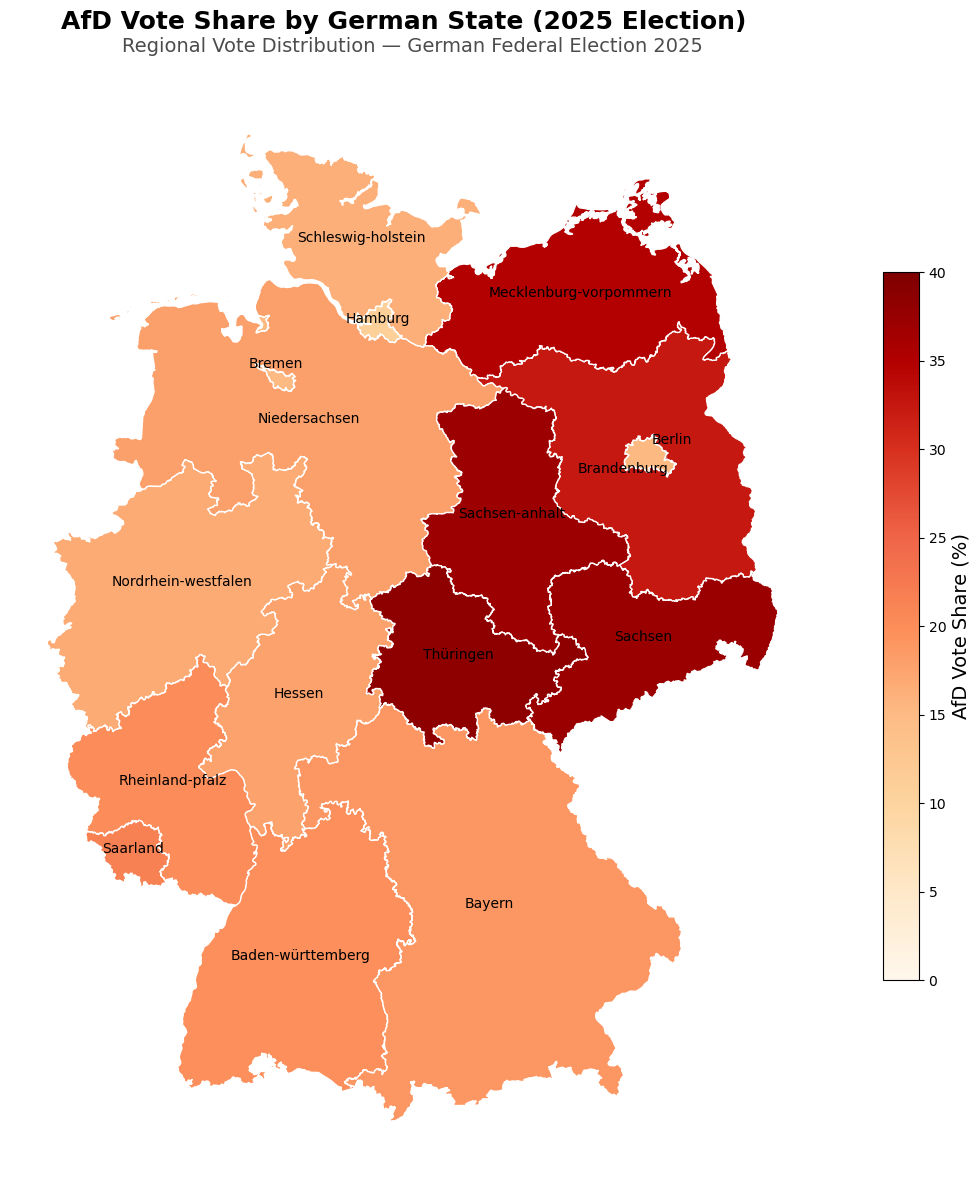

In [44]:
# Loading the GeoDataFrame
gdf = gpd.read_file("gadm41_DEU_1.json")  

# Rename 'Region_Name' to 'State_Name' for consistent merge key with GeoDataFrame
afd_state = afd_state.rename(columns={"Region_Name": "State_Name"})

# Clean state names: strip spaces and lowercase for safer merging
afd_state['State_Name'] = afd_state['State_Name'].str.strip().str.lower()
gdf['NAME_1'] = gdf['NAME_1'].str.strip().str.lower()

# Manual replacements to fix known naming mismatches if needed
afd_state['State_Name'] = afd_state['State_Name'].replace({
    'baden-wurttemberg': 'baden-württemberg',
})

# Merge GeoDataFrame with your exact AfD vote share data
merged_gdf = gdf.merge(afd_state, left_on='NAME_1', right_on='State_Name', how='left')

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
fig.patch.set_facecolor('white')

choropleth = merged_gdf.plot(
    column='Vote_Percent',        
    cmap='OrRd',
    linewidth=1,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'label': "AfD Vote Share (%)",
        'shrink': 0.65,
        'location': 'right',
        'format': '%.0f'          
    },
    vmin=0,
    vmax=40,                     
    ax=ax
)

# Adjusting colorbar font and ticks
colorbar = choropleth.get_figure().get_axes()[1]
colorbar.yaxis.label.set_size(14)
colorbar.yaxis.set_major_locator(mticker.MultipleLocator(5))

# Titles
plt.suptitle("AfD Vote Share by German State (2025 Election)", fontsize=18, weight='bold', y=0.98)
ax.set_title("Regional Vote Distribution — German Federal Election 2025", fontsize=14, alpha=0.7, y=1.02)

# Clean axis
ax.axis('off')

# Adding state labels with manual adjustments for Berlin & Brandenburg
for idx, row in merged_gdf.iterrows():
    if pd.notnull(row['Vote_Percent']):
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        if row['NAME_1'] == 'berlin':
            x += 0.3
            y += 0.1
        elif row['NAME_1'] == 'brandenburg':
            x -= 0.3
            y -= 0.1
        plt.annotate(
            text=row['NAME_1'].capitalize(),
            xy=(x, y),
            horizontalalignment='center',
            fontsize=10,
            fontweight='medium',
            color='black'
        )

plt.tight_layout()
plt.show()


### Explanation
This choropleth map shows the average AfD second vote share by federal state in the 2025 German election. Darker shades indicate higher vote percentages. States in eastern Germany like Sachsen, Thüringen, and Sachsen-Anhalt show the highest support. Western and urban regions such as Hamburg, Bremen, and Berlin exhibit lower AfD vote shares.

### Plot 3: Top 10 Constituencies Where AfD Performed Best (Second Vote)

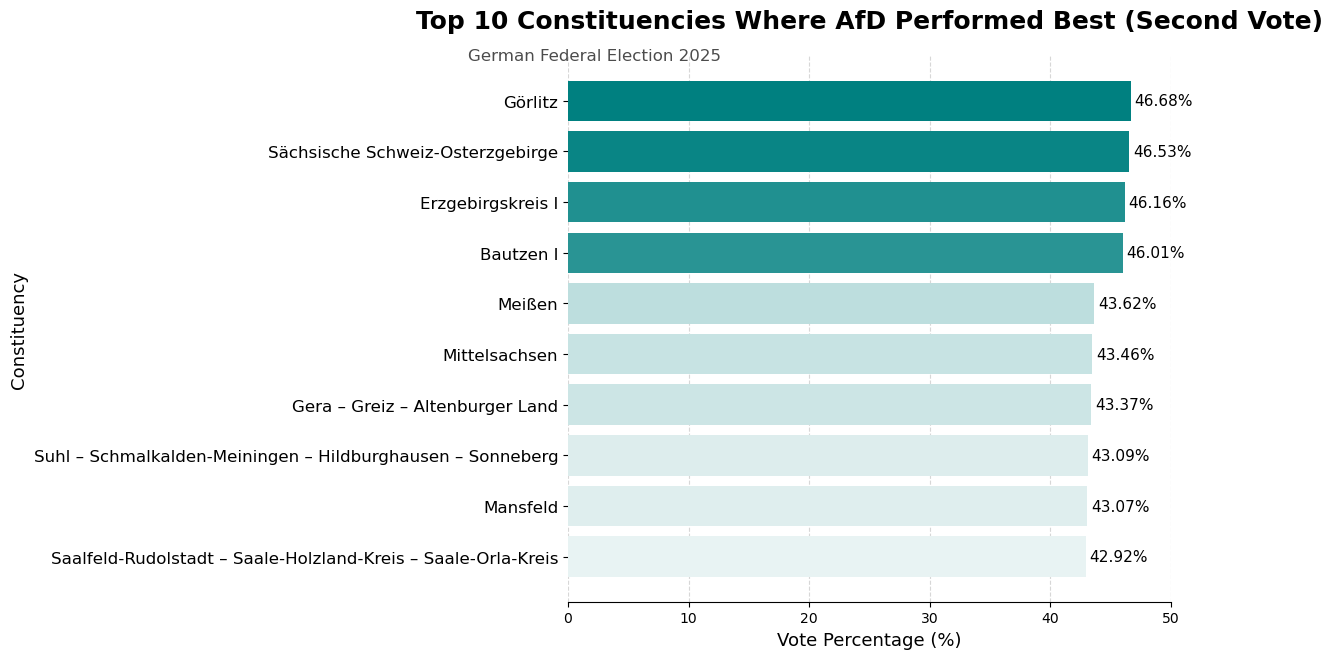

In [47]:
# Step 1: Filter unique constituency & vote % 
top_afd = afd_merged[["Region_Name_kerg2", "Vote_Percent"]].dropna().drop_duplicates()

# Step 2: Sort descending and take top 10
top_afd_sorted = top_afd.sort_values(by="Vote_Percent", ascending=True).tail(10)  
plt.figure(figsize=(12, 7))

# Create color map normalized to vote %
cmap = sns.light_palette("teal", as_cmap=True)  
norm = plt.Normalize(top_afd_sorted["Vote_Percent"].min(), top_afd_sorted["Vote_Percent"].max())
colors = [cmap(norm(v)) for v in top_afd_sorted["Vote_Percent"]]

ax = plt.gca()
y_pos = range(len(top_afd_sorted))

# Plot bars with colors
for i, (value, name) in enumerate(zip(top_afd_sorted["Vote_Percent"], top_afd_sorted["Region_Name_kerg2"])):
    ax.barh(i, value, color=colors[i])
    ax.text(value + 0.3, i, f"{value:.2f}%", va='center', fontsize=11, color='black')

# Y-axis labels and styling
ax.set_yticks(y_pos)
ax.set_yticklabels(top_afd_sorted["Region_Name_kerg2"], fontsize=12)
ax.set_xlabel("Vote Percentage (%)", fontsize=13)
ax.set_ylabel("Constituency", fontsize=13)

# Set x-axis limit to 0-50%
ax.set_xlim(0, 50)

# Titles and subtitle with spacing
plt.title("Top 10 Constituencies Where AfD Performed Best (Second Vote)", fontsize=18, weight='bold', pad=20)
plt.suptitle("German Federal Election 2025", fontsize=12, y=0.88, alpha=0.7)

# Grid and spine cleanup
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


### Explanation 
Top 10 Constituencies Where AfD Performed Best (Second Vote)
This horizontal bar chart highlights the top 10 constituencies where the AfD received the highest share of second votes in the 2025 federal election. Görlitz leads with 46.68%, followed closely by Sächsische Schweiz-Osterzgebirge and Erzgebirgskreis I, each exceeding 46%. All top-performing constituencies are located in eastern Germany, particularly in Saxony and Thuringia.

The AfD’s strongest electoral support is concentrated in specific eastern constituencies, reinforcing regional patterns seen in state-level analysis.

### Plot 4: AfD Vote % vs Unemployment

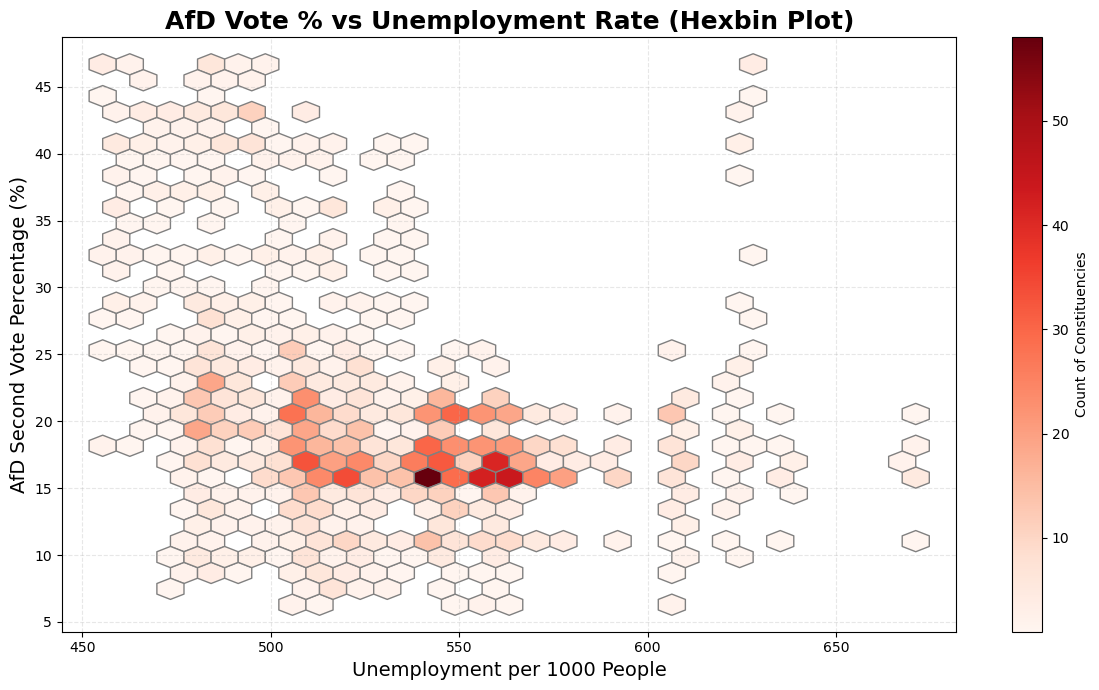

In [50]:
# Filter only rows with valid numeric values
plot_df = afd_merged[["Region_Name_kerg2", "Vote_Percent", "Unemployment_Total"]].dropna()

plt.figure(figsize=(12, 7))

# Hexbin plot with color indicating concentration of points
hb = plt.hexbin(
    plot_df["Unemployment_Total"], 
    plot_df["Vote_Percent"], 
    gridsize=30,         
    cmap='Reds',         
    edgecolors='grey',   
    mincnt=1             
)

# Add colorbar to show counts per hexbin
cb = plt.colorbar(hb)
cb.set_label('Count of Constituencies')

# Plot titles and axis labels with improved styling
plt.title("AfD Vote % vs Unemployment Rate (Hexbin Plot)", fontsize=18, weight='bold')
plt.xlabel("Unemployment per 1000 People", fontsize=14)
plt.ylabel("AfD Second Vote Percentage (%)", fontsize=14)

# Add light grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


### Explanation
This hexbin plot explores the relationship between AfD’s second vote share and the unemployment rate (per 1,000 people) across German constituencies in 2025. Each hexagon represents a cluster of constituencies, with darker shades indicating higher density. Most constituencies fall within the range of 500–560 unemployed per 1,000 people and 15%–25% AfD vote share. While the plot does not show a strong linear correlation, it suggests that AfD support tends to be higher in regions with moderate unemployment levels. This indicates that unemployment may be a contributing but not sole factor in regional voting behavior.

### Plot 5: AfD Vote % vs Population Density

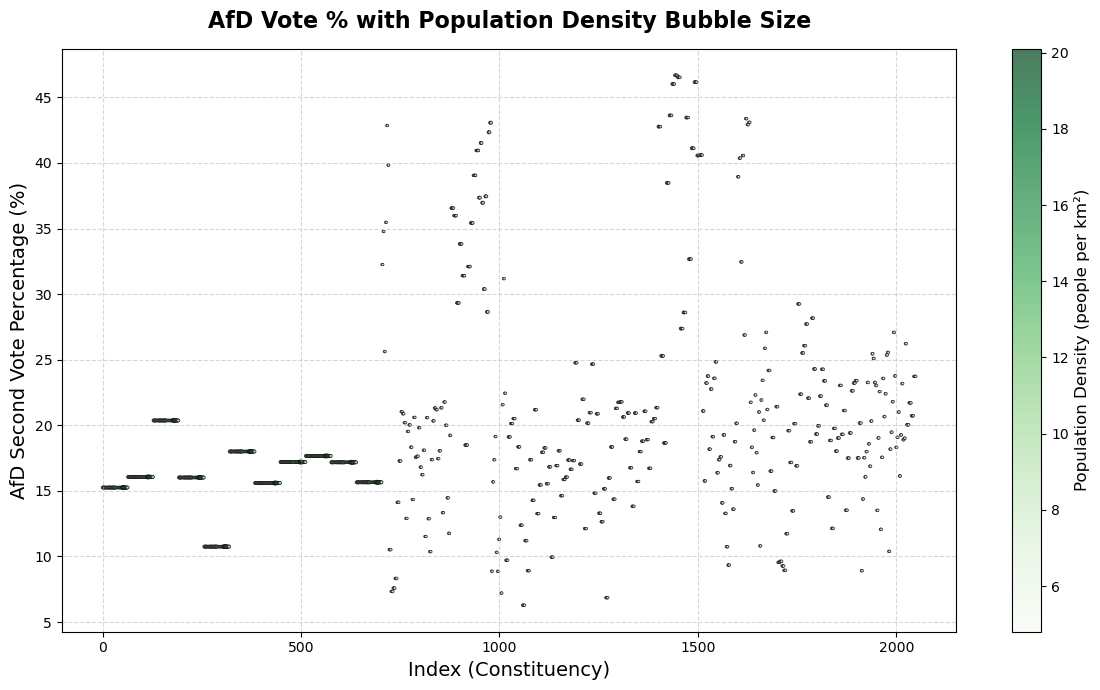

In [53]:
# Filter out rows with missing values
plot_df = afd_merged[["Vote_Percent", "Population_Density"]].dropna()

plt.figure(figsize=(12, 7))

# Scatter plot with bubble size proportional to population density
scatter = plt.scatter(
    plot_df.index, 
    plot_df['Vote_Percent'], 
    s=plot_df['Population_Density'] * 0.5,  
    alpha=0.7,
    c=plot_df['Population_Density'],
    cmap='Greens',
    edgecolors='black',
    linewidth=0.5
)

# Colorbar to indicate Population Density scale
cbar = plt.colorbar(scatter)
cbar.set_label('Population Density (people per km²)', fontsize=12)

# Titles and axis labels
plt.title('AfD Vote % with Population Density Bubble Size', fontsize=16, weight='bold', pad=15)
plt.xlabel('Index (Constituency)', fontsize=14)
plt.ylabel('AfD Second Vote Percentage (%)', fontsize=14)

# Grid for easier reading
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Explanation
This scatter plot illustrates AfD’s second vote share across constituencies, with bubble size and color indicating population density (people per km²). Each point represents a single constituency. Larger and darker green bubbles correspond to areas with higher population density. The x-axis represents the constituency index (arbitrary order), while the y-axis shows AfD vote share. The plot shows that AfD support tends to be lower in highly populated constituencies, where population density is greater. In contrast, smaller bubbles (rural or less dense areas) are more widely spread across higher vote share levels.

### Plot 6: AfD Vote % vs Migration Background 

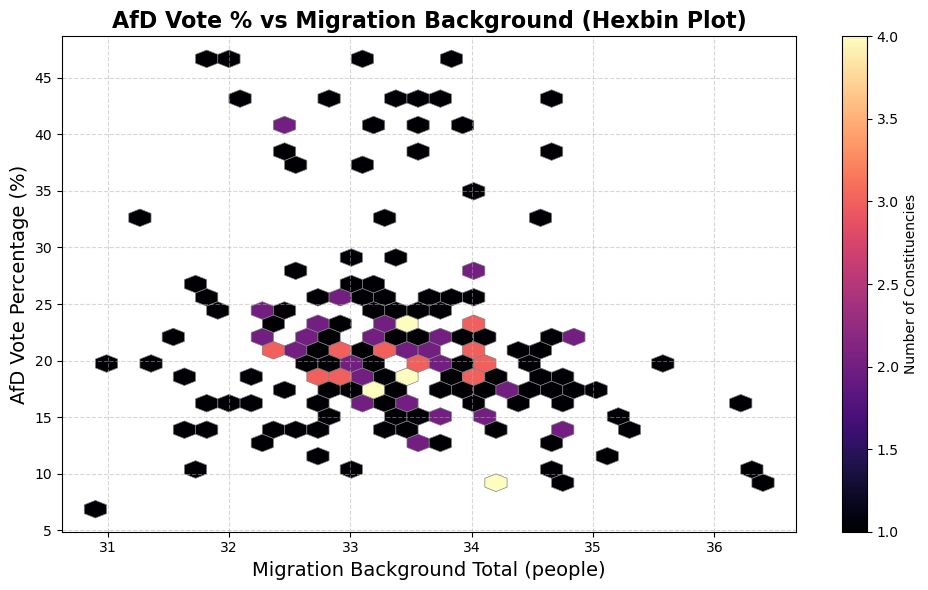

In [56]:
# Step 1: Filter AfD second vote percentages by Region_Code from kerg2
afd_votes = kerg2[
    (kerg2['Group_Name'] == 'AfD') &
    (kerg2['Vote_Type'] == 'Second Vote')
][['Region_Code', 'Vote_Percent']]

# Step 2: Merge with struktur to get Migration_Background_Total by Region_Code
merged_df = pd.merge(
    afd_votes,
    struktur[['Region_Code', 'Migration_Background_Total']],
    on='Region_Code',
    how='left'
)

# Step 3: Drop rows with missing values in key columns
merged_df = merged_df.dropna(subset=['Vote_Percent', 'Migration_Background_Total'])

# Step 4: Plot Hexbin
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    merged_df['Migration_Background_Total'],
    merged_df['Vote_Percent'],
    gridsize=30,
    cmap='magma',
    edgecolors='grey',
    linewidths=0.5,
    mincnt=1  
)
plt.colorbar(hb, label='Number of Constituencies')

plt.title('AfD Vote % vs Migration Background (Hexbin Plot)', fontsize=16, weight='bold')
plt.xlabel('Migration Background Total (people)', fontsize=14)
plt.ylabel('AfD Vote Percentage (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Explanation
This hexbin plot visualizes the relationship between AfD’s vote share and the total number of people with a migration background across German constituencies. Each hexagon represents a cluster of constituencies, with color intensity indicating how many fall within that range. Most constituencies are concentrated between 32–34% migration background and 15–25% AfD vote share.

### Plot 7: Age Distribution of AfD vs Other Candidates

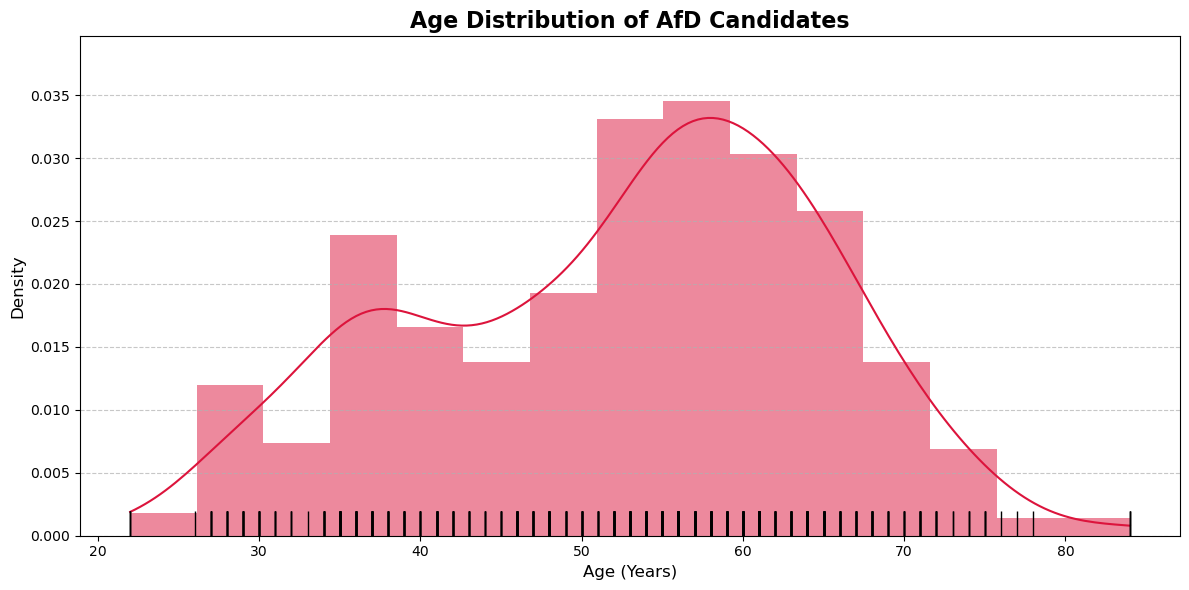

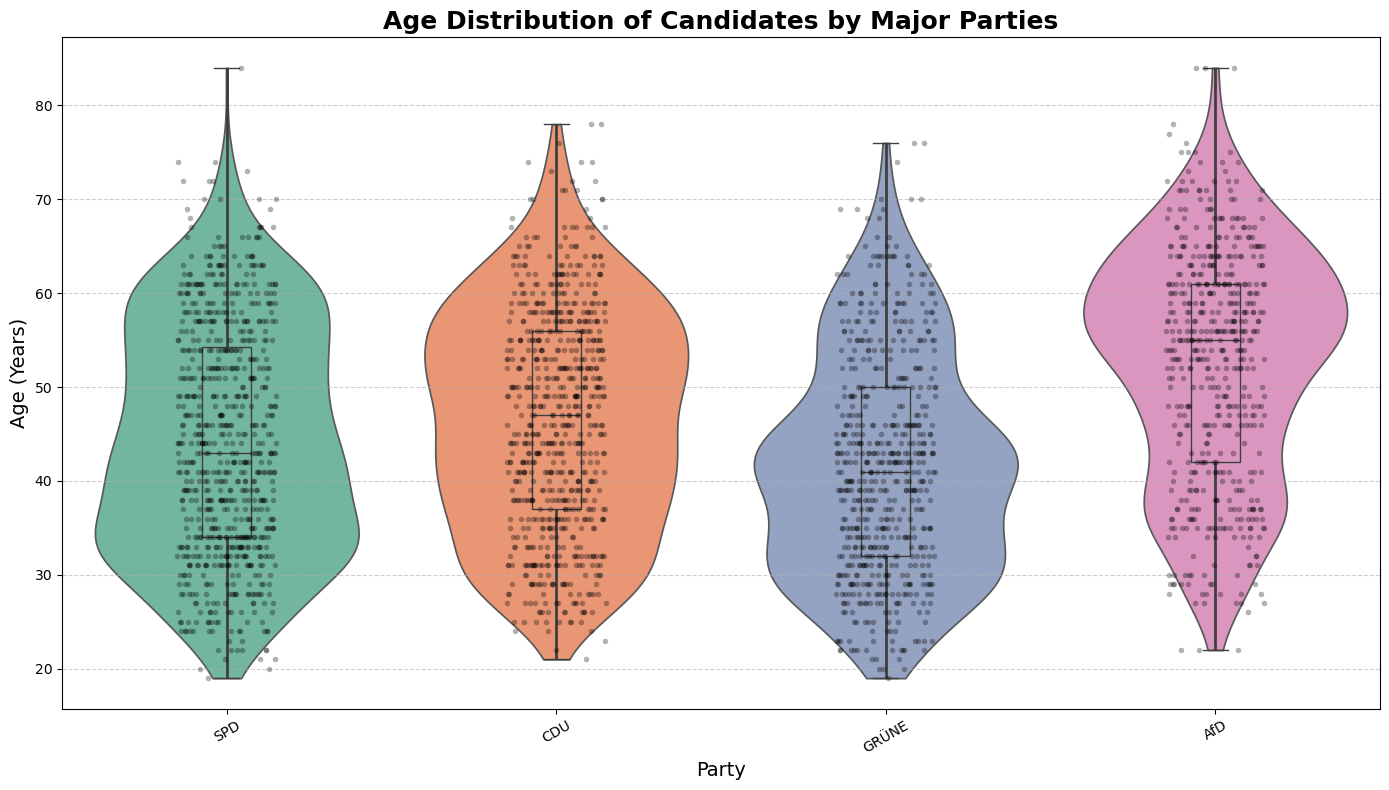

In [59]:
# Calculating the Age 
current_year = datetime.now().year
bewerber['Age'] = current_year - pd.to_numeric(bewerber['Birth_Year'], errors='coerce')

# Cleaning the party column
bewerber['Disqualified'] = bewerber['Disqualified'].astype(str).str.strip()

# Filter valid rows
bewerber_filtered = bewerber.dropna(subset=['Age', 'Disqualified']).copy()
bewerber_filtered['Age'] = bewerber_filtered['Age'].astype(int)

# Define major parties for comparison
major_parties = ['AfD', 'SPD', 'CDU', 'GRÜNE']
bewerber_major = bewerber_filtered[bewerber_filtered['Disqualified'].isin(major_parties)].copy()

# Step 1: Age Distribution of AfD candidates with KDE and Rug plot
plt.figure(figsize=(12, 6))
sns.histplot(
    data=bewerber_major[bewerber_major['Disqualified'] == 'AfD'], 
    x='Age', bins=15, kde=True, color='crimson', stat='density', linewidth=0
)
sns.rugplot(
    data=bewerber_major[bewerber_major['Disqualified'] == 'AfD'], 
    x='Age', height=0.05, color='black'
)
plt.title('Age Distribution of AfD Candidates', fontsize=16, weight='bold')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 2: Violin plot with boxplot and stripplot overlay for Age by Party
plt.figure(figsize=(14, 8))
sns.violinplot(
    x='Disqualified',
    y='Age',
    data=bewerber_major,
    palette='Set2',
    inner=None,
    cut=0,
    hue='Disqualified',  
    legend=False         
)
sns.boxplot(
    x='Disqualified',
    y='Age',
    data=bewerber_major,
    showcaps=True,
    boxprops={'facecolor':'none'},
    showfliers=False,
    whiskerprops={'linewidth':2},
    width=0.15
)
sns.stripplot(
    x='Disqualified',
    y='Age',
    data=bewerber_major,
    color='k',
    alpha=0.3,
    jitter=0.15,
    size=4
)
plt.title('Age Distribution of Candidates by Major Parties', fontsize=18, weight='bold')
plt.xlabel('Party', fontsize=14)
plt.ylabel('Age (Years)', fontsize=14)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Explanation
This analysis compares the age distribution of AfD candidates to those from SPD, CDU, and GRÜNE.

**AfD Histogram**
The KDE-smoothed histogram shows that most AfD candidates are between 50 and 65 years old, with relatively few younger candidates under 35.

**Violin Plot by Party**
The violin plot reveals that:
AfD skews older, with a dense cluster around 50–65 years.
GRÜNE and SPD show broader, younger age distributions.
CDU lies in between, with a slightly older profile.


AfD’s candidate base is notably older than other major parties, highlighting a demographic gap in candidate profiles.



### Plot 8: Gender Representation by Party.

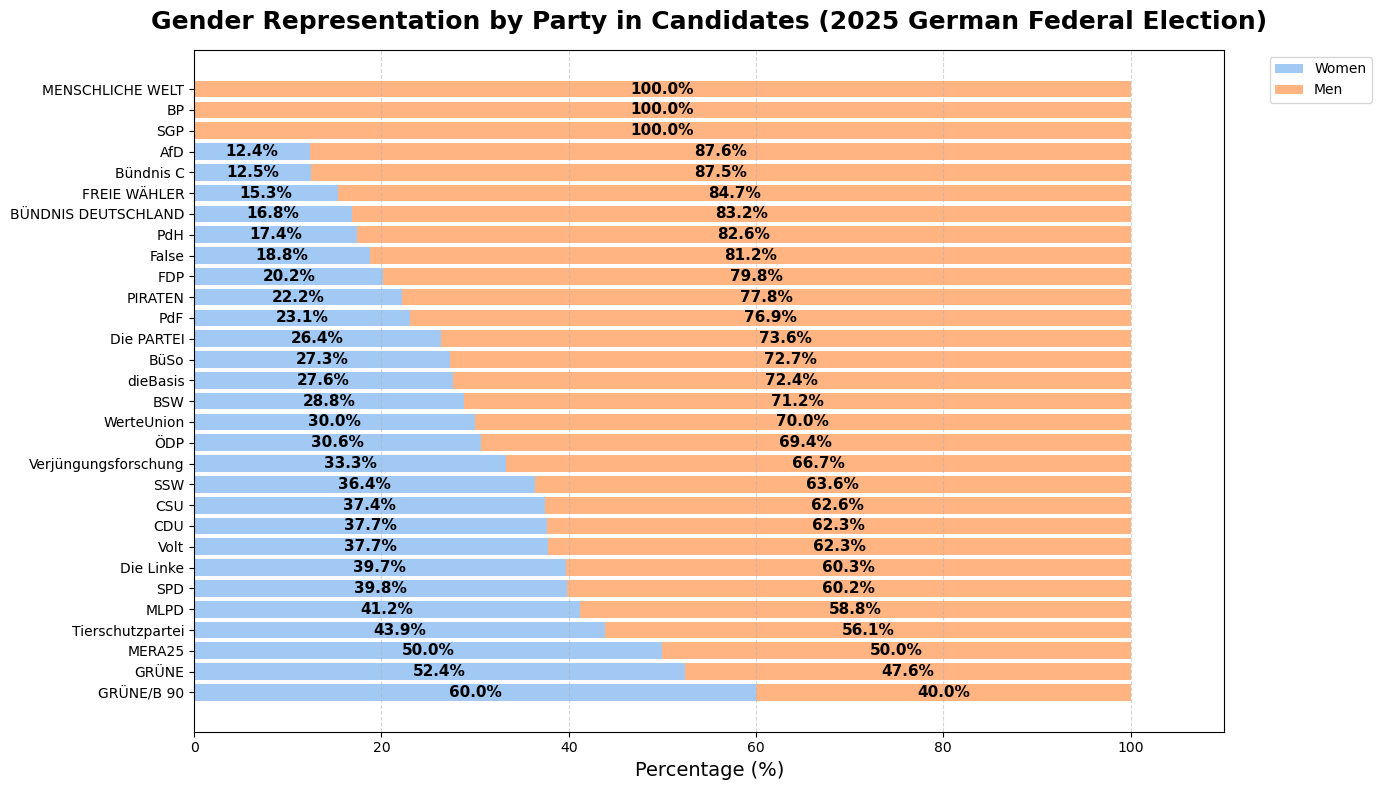

In [62]:
# Cleaning the party and gender columns
bewerber['Disqualified'] = bewerber['Disqualified'].astype(str).str.strip()
bewerber_gender = bewerber.dropna(subset=['Gender', 'Disqualified']).copy()

# Normalize the gender strings to uppercase for consistency
bewerber_gender['Gender'] = bewerber_gender['Gender'].str.upper()

# Define which values denote female 
female_values = ['W', 'F', 'FEMALE']

# Counting total candidates and women candidates per party
total_candidates = bewerber_gender.groupby('Disqualified')['Gender'].count()
women_candidates = bewerber_gender[bewerber_gender['Gender'].isin(female_values)].groupby('Disqualified')['Gender'].count()
men_candidates = total_candidates - women_candidates

# Prepare the DataFrame for plotting
gender_df = pd.DataFrame({
    'Total': total_candidates,
    'Women': women_candidates,
    'Men': men_candidates
}).fillna(0)

# Calculate the proportions for 100% stacked bar plot
gender_df['Women_Percent'] = (gender_df['Women'] / gender_df['Total']) * 100
gender_df['Men_Percent'] = 100 - gender_df['Women_Percent']

# Sort by women percent descending
gender_df = gender_df.sort_values('Women_Percent', ascending=False)

# Plotting
plt.figure(figsize=(14, 8))

# Horizontal stacked bar plot
bars_women = plt.barh(gender_df.index, gender_df['Women_Percent'], color=sns.color_palette('pastel')[0], label='Women')
bars_men = plt.barh(gender_df.index, gender_df['Men_Percent'], left=gender_df['Women_Percent'], color=sns.color_palette('pastel')[1], label='Men')

# Add percentage labels inside bars
for i, (w_perc, m_perc) in enumerate(zip(gender_df['Women_Percent'], gender_df['Men_Percent'])):
    if w_perc > 5:
        plt.text(w_perc/2, i, f"{w_perc:.1f}%", va='center', ha='center', color='black', fontsize=11, fontweight='bold')
    if m_perc > 5:
        plt.text(w_perc + m_perc/2, i, f"{m_perc:.1f}%", va='center', ha='center', color='black', fontsize=11, fontweight='bold')

plt.xlabel('Percentage (%)', fontsize=14)
plt.title('Gender Representation by Party in Candidates (2025 German Federal Election)', fontsize=18, weight='bold', pad=15)

# Move legend outside top right
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.xlim(0, 110)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Explanation
This 100% stacked bar chart shows the proportion of male and female candidates by party.

GRÜNE/B 90 (60%), GRÜNE, and Tierschutzpartei lead in female representation.
AfD (12.4%) and Bündnis C (12.5%) have among the lowest shares of women.
Major parties like SPD and CDU still show a noticeable gender gap.

Gender representation varies widely by party, with progressive parties more balanced and right-leaning parties skewed heavily male.

# Conclusion

This analysis shows a clear east-west divide in AfD support during the 2025 election.

- States like Thüringen, Sachsen, and Sachsen-Anhalt recorded the highest vote shares.
- In contrast, western and urban regions like Hamburg, Bremen, and Berlin showed much lower support.

AfD’s vote share tends to be:

- Higher in rural or less populated areas
- Lower in densely populated urban centers

While factors like unemployment and migration background do not show strong linear correlations, the party performs relatively well in areas with:

- Moderate unemployment
- Lower demographic diversity

Candidate-level data further reveals:

- AfD candidates are generally older
- The party has one of the lowest female representation rates (12%)
- This contrasts with parties like GRÜNE and SPD



**In my opinion:**

If AfD continues to focus on rural and eastern constituencies where they already have strong support and adopts a more moderate and solution-focused tone, they could further expand their base in future elections.

Focusing on local economic concerns, digital infrastructure, housing, and job security may also help attract moderate and disengaged voters.



Overall, this project highlights how geography, demographics, and party image shape voter behavior offering insights not just into what happened in 2025, but also into what may come next.
